In [103]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
from collections import Counter

from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

from vecopsciml.operators.zero_order import Mx, My


In [104]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/non_linear/non_linear_1000.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/non_linear')
MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/non_linear/model_autoencoder_AE')
MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/non_linear/model_autoencoder_NN')


# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_AE_PATH)
create_folder(MODEL_RESULTS_PGNNIV_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear/model_autoencoder_AE
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear/model_autoencoder_NN


In [105]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear/non_linear_1000.pkl


In [106]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [107]:
DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE}")

Using device: cpu


In [108]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1).to(torch.float32)
y_train = torch.Tensor(dataset['y_train']).unsqueeze(1).to(torch.float32)
K_train = torch.tensor(dataset['k_train']).unsqueeze(1).to(torch.float32)
f_train = torch.tensor(dataset['f_train']).unsqueeze(1).to(torch.float32)

X_val = torch.Tensor(dataset['X_val']).to(torch.float32).unsqueeze(1)
y_val = TensOps(torch.Tensor(dataset['y_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

print("Train dataset length:", len(X_train))
print("Validation dataset length:", len(X_val))

Train dataset length: 800
Validation dataset length: 200


In [109]:
N_data_AE = len(X_train)//4
N_data_NN = len(X_train) - len(X_train)//4
prop_data_NN = 1 - N_data_AE/(N_data_NN + N_data_AE)

print("Dataset length for the autoencoder:", N_data_AE)
print("Dataset length for the PGNNIV:", N_data_NN)

X_AE, X_NN, y_AE, y_NN, K_AE, K_NN, f_AE, f_NN = train_test_split(X_train, y_train, K_train, f_train, test_size=prop_data_NN, random_state=42)

Dataset length for the autoencoder: 200
Dataset length for the PGNNIV: 600


In [110]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN, K_train_NN, K_test_NN, f_train_NN, f_test_NN = train_test_split(X_NN, y_NN, K_NN, f_NN, test_size=0.2, random_state=42)

X_train_NN = X_train_NN.to(DEVICE)
X_test_NN = X_test_NN.to(DEVICE)

y_train_NN = TensOps(y_train_NN.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test_NN = TensOps(y_test_NN.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

K_train_NN = TensOps(K_train_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_test_NN = TensOps(K_test_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

f_train_NN = TensOps(f_train_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_test_NN = TensOps(f_test_NN.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

In [111]:
# Predictive network architecture
input_shape = X_train_NN[0].shape
predictive_layers =  [15, 10, 3, 10, 15]
predictive_output = y_train_NN.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train_NN)).values[0].shape
explanatory_layers = [10, 10]
explanatory_output = Mx(My(f_train_NN)).values[0].shape

# Other parameters
n_filters_explanatory = 5

In [112]:
from model.ae_nonlinear_model import AutoencoderNonlinearModel
from model import Autoencoder

In [113]:
y_train_AE, y_test_AE = train_test_split(y_AE, test_size=0.2, random_state=42)

y_train_AE = TensOps(y_train_AE.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test_AE = TensOps(y_test_AE.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

# autoencoder_input_shape = y_train_AE.values[0].shape
# latent_space_dim = 20
# autoencoder_output_shape = y_train_AE.values[0].shape

In [114]:
autoencoder_input_shape = y_train_AE.values[0].shape
latent_space_dim = [15, 10, 3, 10, 15]
autoencoder_output_shape = y_train_AE.values[0].shape

autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

autoencoder, optimizer, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

In [115]:
pretrained_encoder = autoencoder.encoder
pretrained_decoder = autoencoder.decoder

In [116]:
# Se carga el modelo y el optimizador
pgnniv_model = AutoencoderNonlinearModel(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                   explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

model, optimizer, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))

In [117]:
time_list = lists['time_list']

train_total_loss_list = lists['train_total_loss_list']
train_e_loss_list = lists['train_e_loss_list']
train_pi1_loss_list = lists['train_pi1_loss_list']
train_pi2_loss_list = lists['train_pi2_loss_list']
train_pi3_loss_list = lists['train_pi3_loss_list']

test_total_loss_list = lists['test_total_loss_list']
test_e_loss_list = lists['test_e_loss_list']
test_pi1_loss_list = lists['test_pi1_loss_list']
test_pi2_loss_list = lists['test_pi2_loss_list']
test_pi3_loss_list = lists['test_pi3_loss_list']

In [118]:
def smooth_curve(data, window_size=100):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

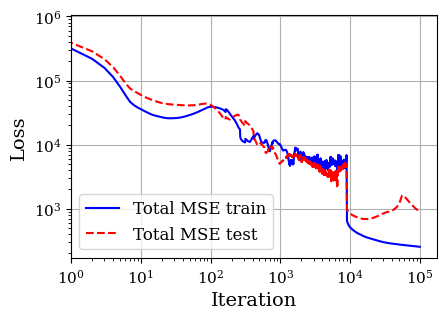

In [119]:
plt.figure(figsize=(width, height))
# plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom) 

plt.plot(smooth_curve(train_total_loss_list), label='Total MSE train', color='blue', linestyle='-')
plt.plot(smooth_curve(test_total_loss_list), label='Total MSE test', color='red', linestyle='--')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
# plt.title('Lineal homogeneous learning curve (MSE)', fontsize=title_fontsize)

plt.grid(True)
plt.legend(loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

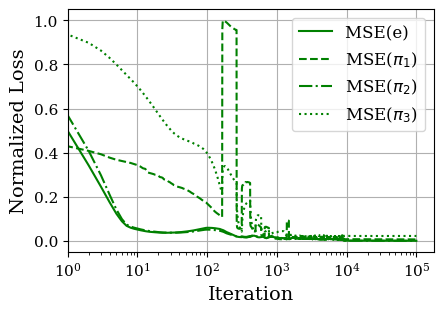

In [120]:
plt.figure(figsize=(width, height))
# plt.subplots_adjust(left=subplot_adjust_left, bottom=subplot_adjust_bottom) 

plt.plot(normalize_list(smooth_curve(train_e_loss_list)), label=r'MSE(e) ', color='green', linestyle='-')
plt.plot(normalize_list(smooth_curve(train_pi1_loss_list)), label=r'MSE($\pi_1$) ', color='green', linestyle='--')
plt.plot(normalize_list(smooth_curve(train_pi2_loss_list)), label=r'MSE($\pi_2$) ', color='green', linestyle='-.')
plt.plot(normalize_list(smooth_curve(train_pi3_loss_list)), label=r'MSE($\pi_3$) ', color='green', linestyle=':')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Normalized Loss', fontsize=label_fontsize)
# plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.xscale('log')
# plt.yscale('log')
plt.xlim(left=1) 

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'penalties_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

In [121]:
def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
    print(f"Máximo: {maximo:.2e}")


def relative_error_return_Q(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx)/
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))
    
    tercer_cuartil = np.percentile(prediction_error, 75)

    Q_bool = prediction_error <= tercer_cuartil

    return Q_bool

In [122]:
y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred, space_dimension=2, contravariance=0, covariance=0)

### Solution $u(x,y)$

In [123]:
u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

relative_error_stats(u_validation, u_prediction)

Mínimo: 1.20e-04
Primer cuartil (Q1): 2.23e-04
Mediana (Q2): 2.96e-04
Tercer cuartil (Q3): 4.67e-04
Máximo: 3.38e-02


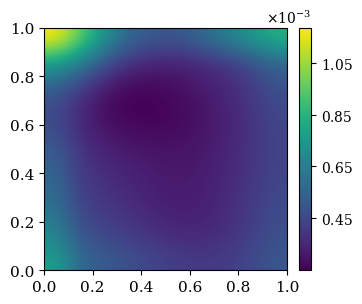

In [124]:
plt.figure(figsize=(height*1.2, height))

u_diff = torch.mean(torch.abs(u_prediction - u_validation), axis=0).squeeze()
plt.imshow(u_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'solution_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Solution $u_m(x, y)$

In [125]:
um_validation = zo.Mx(zo.My(y_val)).values.detach()
um_prediction = zo.Mx(zo.My(y_pred)).values.detach()

relative_error_stats(um_validation, um_prediction)

Mínimo: 9.58e-05
Primer cuartil (Q1): 1.78e-04
Mediana (Q2): 2.55e-04
Tercer cuartil (Q3): 3.70e-04
Máximo: 3.34e-02


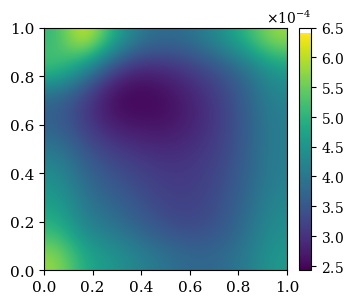

In [126]:
plt.figure(figsize=(height*1.2, height))

um_diff = torch.mean(torch.abs(um_prediction - um_validation), axis=0).squeeze()
plt.imshow(um_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[0:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

plt.show()

### Diffusivity $K(u) = u(1-u)$

In [127]:
K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

relative_error_stats(K_validation, K_prediction)

Mínimo: 1.05e-02
Primer cuartil (Q1): 2.66e-02
Mediana (Q2): 4.21e-02
Tercer cuartil (Q3): 6.23e-02
Máximo: 2.04e-01


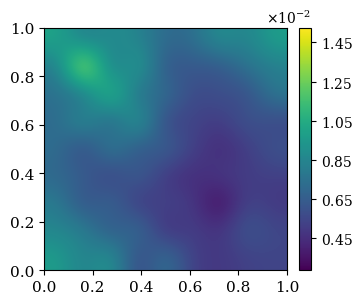

In [128]:
plt.figure(figsize=(height*1.2, height))

K_diff = torch.mean(torch.abs(K_prediction - K_validation), axis=0).squeeze()
plt.imshow(K_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.0005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'diffusivity_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Flux $q_x(x, y)$

In [129]:
qx_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qx_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qx_prediction = azo.scalar_product(K_pred, zo.Dx(y_pred, D)).values.detach()

relative_error_stats(qx_validation, qx_prediction)

Mínimo: 1.12e-02
Primer cuartil (Q1): 2.83e-02
Mediana (Q2): 4.32e-02
Tercer cuartil (Q3): 6.12e-02
Máximo: 1.62e+00


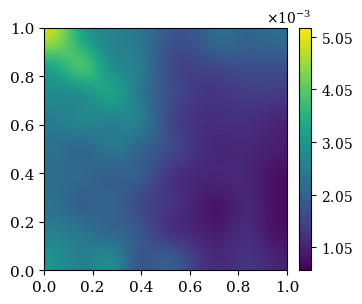

In [130]:
plt.figure(figsize=(height*1.2, height))

qx_diff = torch.mean(torch.abs(qx_prediction - qx_validation), axis=0).squeeze()
plt.imshow(qx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'qx_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

### Flux $q_y(x, y)$

In [131]:
qy_validation = zo.Mx(zo.My(TensOps(torch.Tensor(dataset['qy_val']).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0))).values.detach()
qy_prediction = azo.scalar_product(K_pred, zo.Dy(y_pred, D)).values.detach()

relative_error_stats(qy_validation, qy_prediction)

Mínimo: 1.14e-02
Primer cuartil (Q1): 2.89e-02
Mediana (Q2): 4.32e-02
Tercer cuartil (Q3): 6.03e-02
Máximo: 2.56e+02


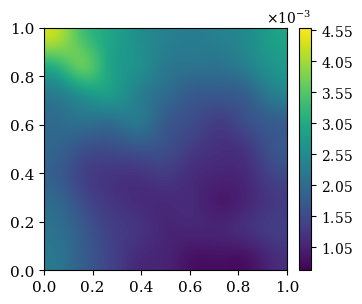

In [132]:
plt.figure(figsize=(height*1.2, height))

qy_diff = torch.mean(torch.abs(qy_prediction - qy_validation), axis=0).squeeze()
plt.imshow(qy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

# Obtener los ticks generados automáticamente
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.00005)
cbar.set_ticks(new_ticks[1:-1])

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'qy_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

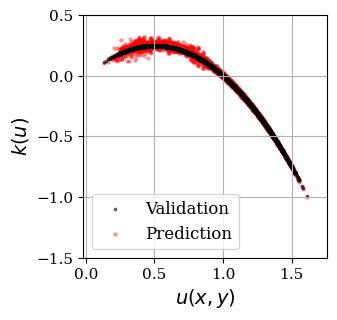

In [133]:
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

plt.figure(figsize=(height, height))
plt.scatter(um_prediction.flatten(), K_prediction.flatten(), label='Prediction', color='red', s=5, alpha=0.3)
plt.scatter(um_validation.flatten(), K_validation.flatten(), label='Validation', color='black', s=3, alpha=0.5)

plt.xlabel('$u(x, y)$', fontsize=label_fontsize)
plt.ylabel('$k(u)$', fontsize=label_fontsize)
# plt.title('Lineal homogeneous normalized learning curves', fontsize=s)

plt.grid(True)
# Obtener la leyenda actual y cambiar el orden
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Cambiar el orden de las etiquetas aquí (Validation primero, Prediction segundo)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower left', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)


min = torch.min(um_validation.flatten()) - 0.1*(torch.max(um_validation.flatten() - torch.min(um_validation.flatten())))
max = torch.max(um_validation.flatten()) + 0.1*(torch.max(um_validation.flatten() - torch.min(um_validation.flatten())))

plt.xlim(min, max)
plt.ylim(-1.5, 0.5)

# plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'ku_vs_u_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
plt.show()

In [134]:
er = np.sum(np.trapz(np.trapz(K_prediction - K_validation, dx=dx), dx=dy))**2/np.sum(np.trapz(np.trapz(K_validation, dx=dx), dx=dy))**2

print(f"er(K): {er:.2e}")

er(K): 1.18e+00


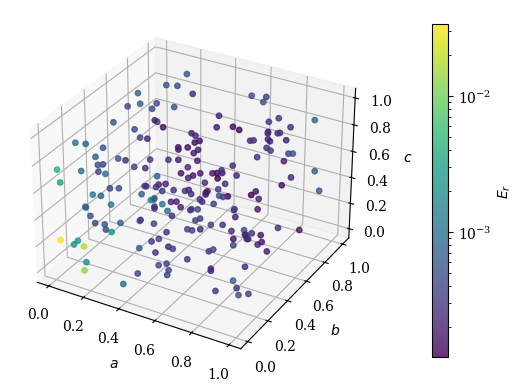

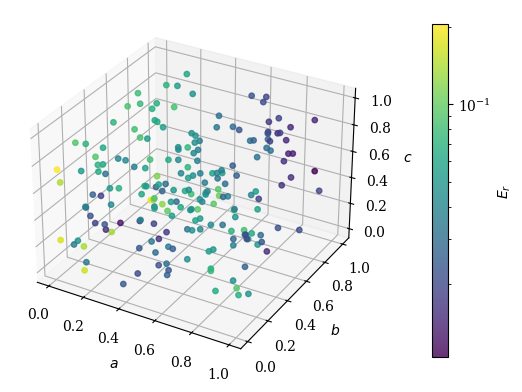

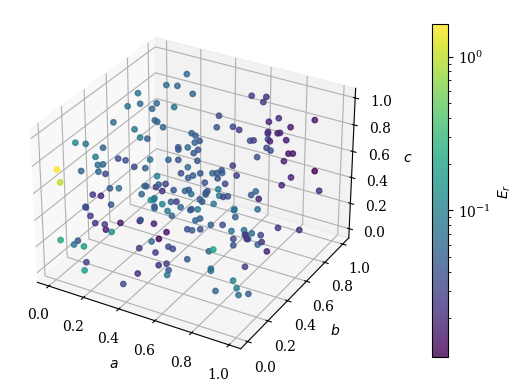

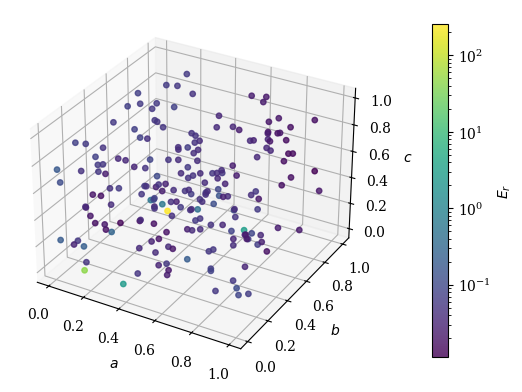

In [135]:
def relative_error(validation, prediction, dx=dx, dy=dy):
    return np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx)/
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator/denominator)
    return result

E_K = relative_error(K_validation, K_prediction)
E_solution = relative_error(u_validation, u_prediction)
E_qx = relative_error(qx_validation, qx_prediction)
E_qy = relative_error(qy_validation, qy_prediction)

a = dataset['g1_val']
b = dataset['g2_val']
c = dataset['g3_val']

def plot_error(a, b, c, error, variable):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(a, b, c, c=error, cmap='viridis', s=15, alpha=0.8, norm=mcolors.LogNorm())
    cbar = plt.colorbar(sc, pad=0.12, shrink=0.9)
    cbar.set_label('$E_r$')

    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_zlabel('$c$')

    # plt.savefig(os.path.join(MODEL_RESULTS_PATH, f'{variable}_val_error_parameters_non_lineal_P4.pdf'), bbox_inches='tight', dpi=600)
    plt.show()

plot_error(a=a, b=b, c=c, error=E_solution, variable='solution')
plot_error(a=a, b=b, c=c, error=E_K, variable='K')
plot_error(a=a, b=b, c=c, error=E_qx, variable='qx')
plot_error(a=a, b=b, c=c, error=E_qy, variable='qy')

In [136]:
# Datos de las listas
lists = {
    "time_list": time_list,
    "train_total_loss_list": train_total_loss_list,
    "train_e_loss_list": train_e_loss_list,
    "train_pi1_loss_list": train_pi1_loss_list,
    "train_pi2_loss_list": train_pi2_loss_list,
    "train_pi3_loss_list": train_pi3_loss_list,
    "test_total_loss_list": test_total_loss_list,
    "test_e_loss_list": test_e_loss_list,
    "test_pi1_loss_list": test_pi1_loss_list,
    "test_pi2_loss_list": test_pi2_loss_list,
    "test_pi3_loss_list": test_pi3_loss_list,
}

# Ruta para guardar
output_path = ROOT_PATH + "/results/models_comparison/data_comparison"

# Asegúrate de que la ruta existe
os.makedirs(output_path, exist_ok=True)

# Nombre del archivo
output_file = os.path.join(output_path, "AE_model_curves.json")

# Guardar en formato JSON
with open(output_file, 'w') as f:
    json.dump(lists, f, indent=4)

print(f"Datos guardados exitosamente en: {output_file}")

Datos guardados exitosamente en: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/models_comparison/data_comparison/AE_model_curves.json
